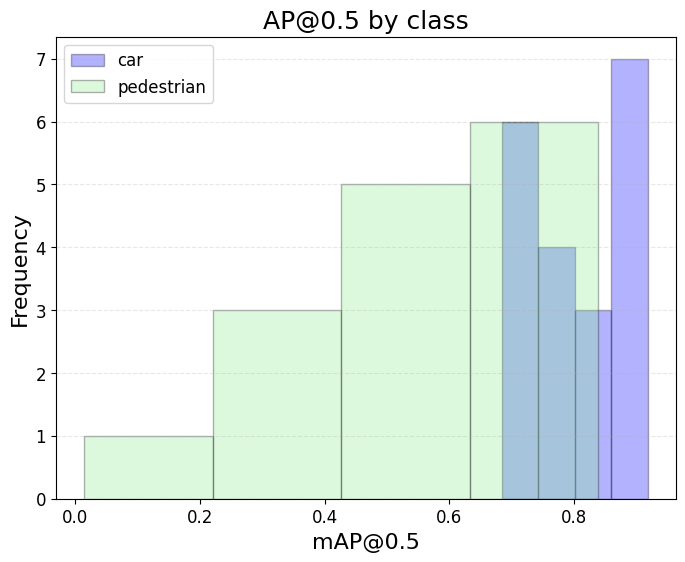

In [54]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_evaluation_file(file_path):
    """Parses the evaluation file and extracts mAP@0.5 for each class in each video."""
    class_map = defaultdict(list)
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    current_class = None
    
    for line in lines:
        video_match = re.match(r'=== Video: (\d+) ===', line)
        class_match = re.match(r'--- Class: (\w+) \(ID: \d+\) ---', line)
        map_match = re.match(r'\s*Average Precision.*IoU=0.50\s+\| area=\s+all \| maxDets=100 \] = ([0-9\.]+)', line)
        
        if class_match:
            current_class = class_match.group(1)
        elif map_match and current_class:
            class_map[current_class].append(float(map_match.group(1)))
    
    return class_map

def plot_histograms(class_map):
    """Plots a single histogram with different colors for each class based on mAP@0.5 values."""
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'lightgreen']  # Define a set of colors
    
    for idx, (class_name, values) in enumerate(class_map.items()):
        plt.hist(values, bins=4, alpha=0.3, color=colors[idx % len(colors)], edgecolor='black', label=class_name)
    
    plt.xlabel('mAP@0.5', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('AP@0.5 by class', fontsize=18)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

# Ejemplo de uso
file_path = "/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/evaluation/per_class_metrics.txt"  # Reemplázalo con la ruta de tu archivo
class_map = parse_evaluation_file(file_path)
plot_histograms(class_map)


In [37]:
import json
import cv2
import os
import numpy as np
from tqdm import tqdm

def draw_boxes(image, annotations, color, label_prefix=""):
    """
    Dibuja cajas en la imagen según las anotaciones proporcionadas.
    """
    for ann in annotations:
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']
        score = ann.get('score', None)  # Solo predicciones tienen score

        label = f"{label_prefix}ID:{category_id}"
        if score is not None:
            label += f" {score:.2f}"

        # Dibujar rectángulo
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)

        # Poner etiqueta
        cv2.putText(image, label, (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, color, 2, cv2.LINE_AA)
    return image

def create_video_from_coco(gt_file, pred_file, frames_folder, output_video, fps=30):
    """
    Genera un video con las detecciones de Ground Truth y predicciones sobre los frames.
    """
    # Cargar anotaciones COCO
    with open(gt_file, 'r') as f:
        gt_data = json.load(f)

    with open(pred_file, 'r') as f:
        pred_data = json.load(f)

    # Crear diccionario de anotaciones por imagen
    gt_annotations = {img["id"]: [] for img in gt_data["images"]}
    pred_annotations = {img["id"]: [] for img in gt_data["images"]}

    for ann in gt_data["annotations"]:
        gt_annotations[ann["image_id"]].append(ann)

    for ann in pred_data:
        pred_annotations[ann["image_id"]].append(ann)

    # Obtener lista de imágenes ordenadas por ID
    images = sorted(gt_data["images"], key=lambda x: x["id"])
    
    # Obtener tamaño del video desde el primer frame
    first_frame = cv2.imread(os.path.join(frames_folder, '000000.png'))
    height, width, _ = first_frame.shape

    # Inicializar el escritor de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    frames_list = os.listdir(frames_folder)

    for i, img in enumerate(images):
        frame_path = os.path.join(frames_folder, frames_list[i])
        frame = cv2.imread(frame_path)
        if frame is None:
            continue  # Saltar si el frame no se encuentra

        image_id = img["id"]

        # Dibujar Ground Truth en verde
        frame = draw_boxes(frame, gt_annotations.get(image_id, []), (0, 255, 0), "GT ")

        # Dibujar predicciones en rojo
        frame = draw_boxes(frame, pred_annotations.get(image_id, []), (0, 0, 255), "Pred ")

        # Escribir frame en el video
        video_writer.write(frame)

    video_writer.release()
    print(f"✅ Video guardado en: {output_video}")

# 📌 Ejemplo de uso:
gt = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/ground_truth/gt_coco_0006.json'
preds = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/predictions/preds_coco_0006.json'
frames = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_02/0006'

output_video = "output.mp4"

create_video_from_coco(gt, preds, frames, output_video)

✅ Video guardado en: output.mp4


In [4]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

def class_name(class_id: int):
    if class_id == 2:
        return "pedestrian"
    elif class_id == 1:
        return "car"
    
def load_json_data(json_file):
    """Load JSON data from a file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def process_frame_with_boxes(image_path, gt_data=None, pred_data=None, show_gt=True, show_pred=True):
    """
    Process an image and overlay bounding boxes from ground truth and prediction data.
    
    Args:
        image_path (str): Path to the image file
        gt_data (dict): Ground truth data in COCO format
        pred_data (list): Prediction data as a list of annotation dictionaries
        show_gt (bool): Whether to show ground truth boxes
        show_pred (bool): Whether to show prediction boxes
    
    Returns:
        numpy.ndarray: Processed image with bounding boxes
    """
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    
    # Extract image ID from filename (assuming format like 000123.png)
    filename = os.path.basename(image_path)
    frame_number = int(os.path.splitext(filename)[0])
    
    # Find image ID in ground truth data
    image_id = None
    if gt_data is not None:
        for img_info in gt_data.get('images', []):
            if frame_number == img_info.get('id') or filename == os.path.basename(img_info.get('file_name', '')):
                image_id = img_info.get('id')
                break
    
    if image_id is None:
        return image  # No annotations for this image
    
    # Draw ground truth boxes if available
    if show_gt and gt_data is not None:
        for ann in gt_data.get('annotations', []):
            if ann.get('image_id') == image_id:
                bbox = ann.get('bbox', [])
                category_id = ann.get('category_id', 0)
                if len(bbox) == 4:  # Ensure bbox has correct format [x, y, width, height]
                    x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
                    # Draw green box for ground truth
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Draw prediction boxes if available
    if show_pred and pred_data is not None:
        for ann in pred_data:
            if ann.get('image_id') == image_id:
                bbox = ann.get('bbox', [])
                category_id = ann.get('category_id', 0)
                if len(bbox) == 4:  # Ensure bbox has correct format
                    x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
                    # Draw red box for predictions
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                    # Add label with score
                    cv2.putText(image, f"{class_name(category_id)}", (x, y - 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    return image

def create_video_from_frames(input_dir, output_file, gt_data=None, pred_data=None, show_gt=True, show_pred=True, fps=20):
    """
    Create a video from frames with bounding boxes for detections
    
    Args:
        input_dir (str): Directory containing image frames
        output_file (str): Path to save the output video
        gt_data (dict): Ground truth data in COCO format
        pred_data (list): Prediction data as a list of annotation dictionaries
        show_gt (bool): Whether to show ground truth boxes
        show_pred (bool): Whether to show prediction boxes
        fps (int): Frames per second for output video
    """
    # Get all frame files sorted
    frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))])
    
    if not frame_files:
        print(f"No image files found in {input_dir}")
        return
    
    # Get first frame to determine video dimensions
    first_frame_path = os.path.join(input_dir, frame_files[0])
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        print(f"Failed to read first frame: {first_frame_path}")
        return
    
    height, width, _ = first_frame.shape
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    print(f"Creating video from {len(frame_files)} frames...")
    
    # Process each frame and add to video
    for frame_file in tqdm(frame_files):
        frame_path = os.path.join(input_dir, frame_file)
        processed_frame = process_frame_with_boxes(
            frame_path, gt_data, pred_data, show_gt, show_pred
        )
        
        if processed_frame is not None:
            video_writer.write(processed_frame)
    
    # Release resources
    video_writer.release()
    print(f"Video saved to {output_file}")


video = '0006'
# Example usage
gt_file = f"/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/ground_truth/gt_coco_{video}.json"
gt_data = load_json_data(gt_file)

pred_file = f'/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/predictions/preds_coco_{video}.json'
pred_data = load_json_data(pred_file)

# Path to image frames directory
image_dir = f"/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_02/{video}"

# Path for output video
output_video = "/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/output_video_with_both_detections.mp4"

# Create video with both ground truth and prediction bounding boxes
create_video_from_frames(
    input_dir=image_dir,
    output_file=output_video,
    gt_data=gt_data,
    pred_data=pred_data,  # Including prediction data
    show_gt=True,
    show_pred=True,  # Show predictions
    fps=10
)

Creating video from 270 frames...


100%|██████████| 270/270 [00:03<00:00, 89.23it/s]

Video saved to /Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/output_video_with_both_detections.mp4


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [31]:
import cv2
import numpy as np
from PIL import Image

def video_to_gif(video_path, output_path="output.gif", duration=100, loop=0):
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Fin del video

        # Convertir a RGB (cv2 usa BGR por defecto)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


        frames.append(Image.fromarray(frame))

    cap.release()  # Liberar el video

    if frames:
        frames[0].save(output_path, save_all=True, append_images=frames[0:], duration=duration, loop=loop)
        print(f"GIF saved at {output_path}")
    else:
        print("Error: No frames extracted from video.")

path_video = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/conos.mp4'
video_to_gif(path_video, "output.gif", duration=150, loop=0)

GIF saved at output.gif


In [29]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_json_data(json_file):
    """Load JSON data from a file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def draw_label(img, text, x, y, color=(0, 0, 255), font_scale=0.3, thickness=1):
    """
    Draws a text label with a semi-transparent background.
    
    Args:
        img: Image on which to draw
        text: Text to display
        x, y: Position of the text
        color: Text color
        font_scale: Font size
        thickness: Thickness of the text
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_w, text_h = text_size[0], text_size[1]

    # Background rectangle
    bg_x1, bg_y1 = x, y - text_h - 5
    bg_x2, bg_y2 = x + text_w + 10, y
    overlay = img.copy()
    cv2.rectangle(overlay, (bg_x1, bg_y1), (bg_x2, bg_y2), color, -1)

    # Blend with transparency
    alpha = 0.4  # Transparency factor
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    # Draw text
    cv2.putText(img, text, (x + 5, y - 5), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

def process_frame_with_boxes(image_path, gt_data=None, pred_data=None, show_gt=True, show_pred=True, category_map={}):
    """
    Process an image and overlay bounding boxes from ground truth and prediction data with a modern look.
    
    Args:
        image_path (str): Path to the image file
        gt_data (dict): Ground truth data in COCO format
        pred_data (list): Prediction data as a list of annotation dictionaries
        show_gt (bool): Whether to show ground truth boxes
        show_pred (bool): Whether to show prediction boxes
        category_map (dict): Mapping of category IDs to category names
    
    Returns:
        numpy.ndarray: Processed image with bounding boxes
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None

    filename = os.path.basename(image_path)
    frame_number = int(os.path.splitext(filename)[0])

    image_id = None
    if gt_data is not None:
        for img_info in gt_data.get('images', []):
            if frame_number == img_info.get('id') or filename == os.path.basename(img_info.get('file_name', '')):
                image_id = img_info.get('id')
                break

    if image_id is None:
        return image  # No annotations for this image

    # Draw ground truth boxes (only rectangles, no text)
    if show_gt and gt_data is not None:
        for ann in gt_data.get('annotations', []):
            if ann.get('image_id') == image_id:
                bbox = ann.get('bbox', [])
                if len(bbox) == 4:
                    x, y, w, h = map(int, bbox)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Draw prediction boxes (with class name, but no confidence score)
    if show_pred and pred_data is not None:
        for ann in pred_data:
            if ann.get('image_id') == image_id:
                bbox = ann.get('bbox', [])
                category_id = ann.get('category_id', 0)
                class_name = category_map.get(category_id, f"ID {category_id}")

                if len(bbox) == 4:
                    x, y, w, h = map(int, bbox)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                    draw_label(image, class_name, x, y)

    return image

def create_video_from_frames(input_dir, output_file, gt_data=None, pred_data=None, show_gt=True, show_pred=True, fps=20, category_map={}):
    """
    Create a video from frames with bounding boxes for detections with improved visualization.
    
    Args:
        input_dir (str): Directory containing image frames
        output_file (str): Path to save the output video
        gt_data (dict): Ground truth data in COCO format
        pred_data (list): Prediction data as a list of annotation dictionaries
        show_gt (bool): Whether to show ground truth boxes
        show_pred (bool): Whether to show prediction boxes
        fps (int): Frames per second for output video
        category_map (dict): Mapping of category IDs to category names
    """
    frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))])

    if not frame_files:
        print(f"No image files found in {input_dir}")
        return

    first_frame_path = os.path.join(input_dir, frame_files[0])
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        print(f"Failed to read first frame: {first_frame_path}")
        return

    height, width, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    print(f"Creating video from {len(frame_files)} frames...")

    for frame_file in tqdm(frame_files):
        frame_path = os.path.join(input_dir, frame_file)
        processed_frame = process_frame_with_boxes(
            frame_path, gt_data, pred_data, show_gt, show_pred, category_map
        )

        if processed_frame is not None:
            video_writer.write(processed_frame)

    video_writer.release()
    print(f"Video saved to {output_file}")

video = '0008'
# Example usage
gt_file = f"/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/ground_truth/gt_coco_{video}.json"
gt_data = load_json_data(gt_file)

pred_file = f'/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/evaluation_results/off-the-shelf/predictions/preds_coco_{video}.json'
pred_data = load_json_data(pred_file)

# Path to image frames directory
image_dir = f"/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_02/{video}"

# Path for output video
output_video = "/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/output_video_with_both_detections.mp4"


# Example category map (replace with your actual categories)
category_map = {
    1: "car",
    2: "pedestrian",
}

create_video_from_frames(
    input_dir=image_dir,
    output_file=output_video,
    gt_data=gt_data,
    pred_data=pred_data,
    show_gt=True,
    show_pred=True,
    fps=10,
    category_map=category_map
)


Creating video from 390 frames...


100%|██████████| 390/390 [00:04<00:00, 82.92it/s]

Video saved to /Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/output_video_with_both_detections.mp4
